In [1]:
#using Pkg;
#Pkg.add("NetCDF")
using Pkg; Pkg.activate(".."); Pkg.instantiate()
using OceanTurb, Printf
using BenchmarkTools
using Plots
using Distributions
using Statistics
using Random
using Base
using NetCDF

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Info: Recompiling stale cache file /Users/andresouza/.julia/compiled/v1.0/OceanTurb/9iboO.ji for OceanTurb [d848d694-35fd-11e9-1c91-9995598ac29e]
└ @ Base loading.jl:1187


In [2]:
#first import LES data
numimport = 3
numimport_plot = 3
name = "free_convection_N128_k1e-4_Float64/convection_"
#name = "convection_"
top_flux = "75.0_"
bot_grad = "0.01_"
grid_points = "128_"
filenum = "000000100"
#filenum = "000126000"
numlist = [lpad("100",9,'0')]
t = [0]
for i in 1:numimport
    tmp = string( i * 3600 )
    tmp = lpad(tmp,9,"0")
    push!(numlist,lpad(tmp,9,"0"))
    push!(t, i * 3600 * 6) #in seconds
end

#load data, ncinfo(filename)
println(numlist)
u = []
v = []
w = []
T_s = [] #simulation temperature
mean_T = []
std_T = []
std_u = []
std_v = []
std_w = []
filename = name  * top_flux * bot_grad * grid_points * numlist[1] *  ".nc"

z = ncread(filename,"zC")
for filenum in numlist
    filename = name  * top_flux * bot_grad * grid_points * filenum *  ".nc"
    println(filename)
    nc_output = ncread(filename,"T")
    tmp = mean(nc_output,dims=[1,2])[1,1,:] .- 273.15
    push!(T_s,tmp)
end


["000000100", "000003600", "000007200", "000010800"]
free_convection_N128_k1e-4_Float64/convection_75.0_0.01_128_000000100.nc
free_convection_N128_k1e-4_Float64/convection_75.0_0.01_128_000003600.nc
free_convection_N128_k1e-4_Float64/convection_75.0_0.01_128_000007200.nc
free_convection_N128_k1e-4_Float64/convection_75.0_0.01_128_000010800.nc


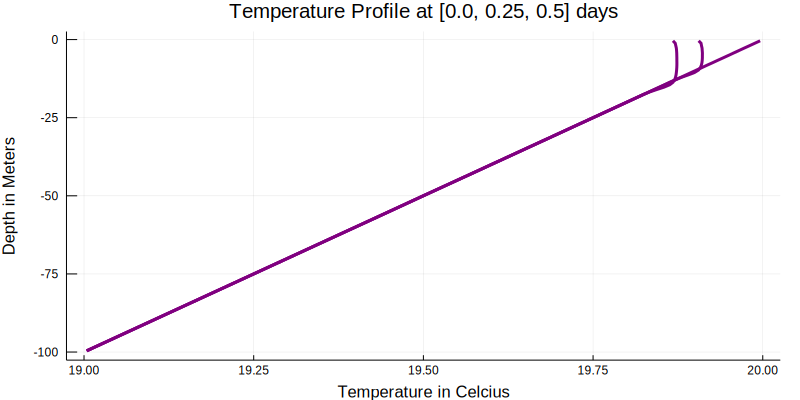

In [3]:
index = 1:3
plot(T_s[index],z,leg=false, title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "purple",lw = 3)

In [4]:
#Gregs Code
# First, we define a model 100 m deep with 1m spacing.
#=
       Cε = 0.1, surface layer fraction, 1
       Cκ = 0.4, von karman constant, 2
       CN = 6.33, nonlocal flux proportion, 3
    Cstab = 2.0, stabilizes F_b, 4
    Cunst = 6.4, destablizes F_b, 5
     Cb_U = 0.599, convection factor, 6
     Cτ_U = 0.135, wind mixing, 7
     Cb_T = 1.36,convection factor, 8
     Cτ_T = -1.85, wind mixing, 9
     Cd_U = 0.5, dont know, 10
     Cd_T = 2.5, dont know, 11
      CRi = 4.32, unresolved kinetic energy, 12
      CKE = 0.3, richardson number criteria, 13
     CKE₀ = 1e-11, 14
=#
params = [0.1 0.4 6.33 2.0 6.4 0.599 0.135 1.36 -1.85 0.5 2.5 4.32 0.3 1e-11]
parameters = KPP.Parameters(
    Cε = params[1], Cκ = params[2], CN = params[3], Cstab = params[4], 
    Cunst = params[5], Cb_U = params[6], Cτ_U = params[7], Cb_T  = params[8],
    Cτ_T = params[9], Cd_U = params[10], Cd_T = params[11], CRi = params[12], CKE = params[13]
)

#parameters = KPP.Parameters()
model = KPP.Model(N=128, L=100.0, parameters=parameters)

# Initial condition
γ = 0.01
T₀(z) = 20 + γ*z
N₀ = sqrt(model.constants.g*model.constants.α*γ)

# Set T to the function T0(z)
model.solution.T = T₀

heat_flux = 75
temperature_flux = heat_flux / (model.constants.ρ₀ * model.constants.cP)
buoyancy_flux = temperature_flux * model.constants.g * model.constants.α

model.bcs.T.top = FluxBoundaryCondition(temperature_flux)
model.bcs.T.bottom = GradientBoundaryCondition(γ)

#now iterate the model
# Time stepping
dt = 6 # seconds
#nt = ceil(Int, 86400 / dt) #seconds to days conversion
nt = 3600 #corresponds to LES simulation, 3600 seconds is 6 hours
ni = 4*4*1  #4 corresponds to 1 day

model.solution.T = T₀
U, V, T, S = model.solution
Tz = ∂z(T)

T_p = []
tmp1 = zeros(128)
tmp = data(model.solution.T)
@. tmp1 = tmp
push!(T_p,tmp1[end:-1:1])

reset!(model.clock)
for i in 1:ni
    iterate!(model, dt, nt)
    tmp = data(model.solution.T)
    @. tmp1 = tmp
    push!(T_p,tmp1[end:-1:1])
    println(i)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


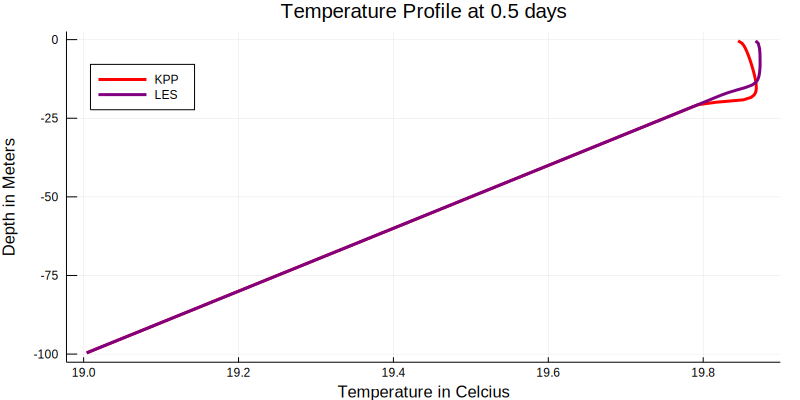

In [5]:
index = 3
plot(T_p[index],z, color = "red",lw = 3, legend=:topleft,label="KPP")
plot!(T_s[index],z, label="LES", title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "purple",lw = 3)

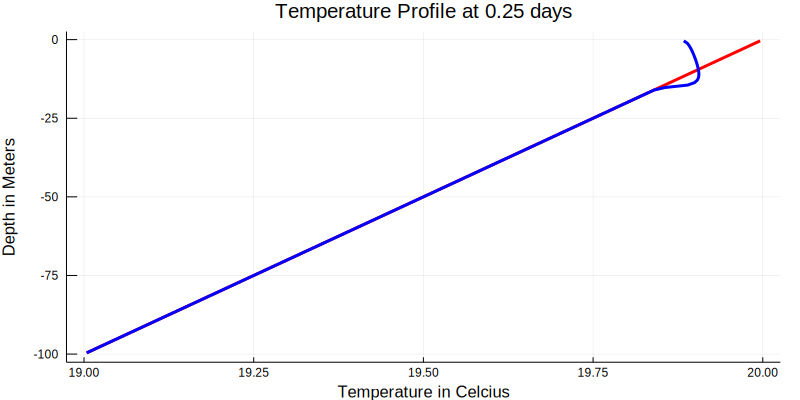

In [6]:
index = 1
plot(T_p[index],z,leg=false, title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "red",lw = 3)
index = 2
plot!(T_p[index],z,leg=false, title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "blue",lw = 3)
#=
index = 3
plot!(T_p[index],z,leg=false, title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "green",lw = 3)
index = 4
plot!(T_p[index],z,leg=false, title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "yellow",lw = 3)
index = 5
plot!(T_p[index],z,leg=false, title = "Temperature Profile at "*string(t[index]/86400)*" days",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "purple",lw = 3)
=#

In [7]:
#check the error
index = 3
mean((T_p[index] .- T_s[index] ).^2 ) / mean(T_s[index] .^2)

2.3328653383301695e-7

In [8]:
mean(T_s[index])-mean(T_p[index])

-8.97712970093778e-5

The slope is 
-1.8252246522039902e-7
The slope is 
-1.825224652205635e-7
The slope is 
-1.825224652205635e-7
The model constant for density is 
1035.0
The model constant for specific heat is
3992.0
The slope should be 
-1.915224652202957e-7
or
-1.8465438400784352e-7


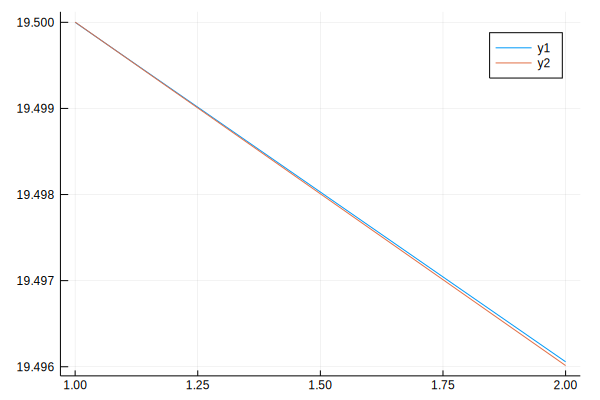

In [11]:
#Check the average temperature growth
mean_Tp = ones(length(T_p))
mean_Ts = ones(length(T_p))
for i in 1:length(T_s)
    mean_Tp[i] = mean(T_p[i])
    mean_Ts[i] = mean(T_s[i])
end
for i in 1:(length(T_s)-1)
    println("The slope is ")
    field = mean_Tp
    slope = (field[i+1]-field[i])/(3600 * dt)
    println(slope)
end
println("The model constant for density is ")
println(model.constants.ρ₀)
println("The model constant for specific heat is")
println(model.constants.cP)
println("The slope should be ")
println(-heat_flux / (model.constants.ρ₀ * model.constants.cP)/100 - 10^(-4)*0.01/100)
p0 = 1027
cp = 4181.3
println("or")
println(-heat_flux / (p0 * cp )/100 - 10^(-4)*0.01/100)
range = 1:2
plot(mean_Tp[range])
plot!(mean_Ts[range])

In [35]:
#Just build the loss function regardless
function loss_function(params,T_s)
parameters = KPP.Parameters(
    Cε = params[1], Cκ = params[2], CN = params[3], Cstab = params[4], 
    Cunst = params[5], Cb_U = params[6], Cτ_U = params[7], Cb_T  = params[8],
    Cτ_T = params[9], Cd_U = params[10], Cd_T = params[11], CRi = params[12], CKE = params[13]
)

    #parameters = KPP.Parameters()
    model = KPP.Model(N=128, L=100.0, parameters=parameters)
    # Initial condition
    γ = 0.01
    T₀(z) = 20 + γ*z
    N₀ = sqrt(model.constants.g*model.constants.α*γ)
    # Set T to the function T0(z)
    model.solution.T = T₀
    heat_flux = 75
    temperature_flux = heat_flux / (model.constants.ρ₀ * model.constants.cP)
    buoyancy_flux = temperature_flux * model.constants.g * model.constants.α

    model.bcs.T.top = FluxBoundaryCondition(temperature_flux)
    model.bcs.T.bottom = GradientBoundaryCondition(γ)

    #now iterate the model
    # Time stepping
    dt = 6 # seconds
    #nt = ceil(Int, 86400 / dt) #seconds to days conversion
    nt = 3600 #corresponds to LES simulation, 3600 seconds is 6 hours
    ni = length(T_s)-1  #4 corresponds to 1 day

    model.solution.T = T₀
    U, V, T, S = model.solution
    Tz = ∂z(T)

    T_p = []
    tmp1 = zeros(128)
    tmp = data(model.solution.T)
    @. tmp1 = tmp
    push!(T_p,tmp1[end:-1:1])

    reset!(model.clock)
    for i in 1:ni
        iterate!(model, dt, nt)
        tmp = data(model.solution.T)
        @. tmp1 = tmp
        push!(T_p,tmp1[end:-1:1])
    end
    loss = 0
    for i in 1:(ni+1)
        loss += mean((T_p[i] .- T_s[i] ).^2 ) / mean(T_s[i] .^2)
    end
    loss *= 1 / (ni+1)
    loss==loss ? loss = loss : loss = Inf
    return loss
end

function loss_function_r(params, T_s, loss_function)
    for j in 1:8
        if params[j] < 0
            return Inf
        end            
    end
    if params[9] > 0
        return Inf
    end
    for j in 10:14
        if params[j] < 0
            return Inf
        end            
    end
    return loss_function(params,T_s)
end

loss_function_r (generic function with 1 method)

In [39]:
params = [0.1 0.4 6.33 2.0 6.4 0.599 0.135 1.36 -1.85 0.5 2.5 4.32 0.3 1e-11]*(1.0)
loss_value1 = loss_function_r(params, T_s,loss_function)

1.7170031861426075e-7

In [14]:
@btime loss_function(params, T_s)

  2.823 s (76084868 allocations: 1.24 GiB)


1.7170031861426075e-7

In [37]:
#params = [40 60 6.33 8.0 8.5 0.599 135 1.36 -1.85 0.5 2.5 4.32 0.3 1e-1]*(1.0)
#loss_value = loss_function(params, T_s)/loss_value1

1.7636111473209717

In [50]:
#Now to do MCMC
#Now to do MCMC
params = [0.1 0.4 6.33 2.0 6.4 0.599 0.135 1.36 -1.85 0.5 2.5 4.32 0.3 1e-11]*(1.0)
#set seed for reproducibility
Random.seed!(1234)
#set initial condition for the simulation
num_sim = 100
plist = zeros(num_sim,length(params))
vlist = ones(num_sim) .* 1000
p0 = deepcopy(params)
x = zeros(num_sim)
#set initial value
plist[1,:] = p0
val_old = loss_function(plist[1,:],T_s) /loss_value1
vlist[1]  = val_old
eps = 1/loss_value1 #references loss value
#apply MCM algorithm
index_not_mod = [ 5 6 7 8 9 10 11 12 13 14] #choose which indices to not modify
index_mod = collect(1:10) #choose which indices to modify
#the idea is to make the variance about 50% of the values
varlist = ones(length(params))
@. varlist = abs(params[1,:])*0.5
xc = zeros(length(params))
for i in 1:(num_sim-1)
    #xc = plist[i,:] + rand(Normal(0, 0.01), length(params))
    #@. xc[indexmod] = plist[i,index_not_mod] #only modify certain indices
    @. xc = plist[i,:]
    for j in index_mod
        xc[j] += rand(Normal(0, varlist[j]))
    end
    r = rand(Uniform(0,1),1)
    log_r = log(r[1])
    #val_new = loss_function_r(xc,T_s,loss_function) #only considers positive constants
    val_new = loss_function(xc,T_s) #lets values be negative
    log_ratio = -eps*(val_new - val_old)
    log_r < log_ratio ? plist[i+1,:]=copy(xc) : plist[i+1,:] = copy(plist[i,:])
    val_old = val_new
    vlist[i+1] = val_old /loss_value1
    i%20==0 ? println("iteration "*string(i)) : nothing
end

iteration 20
iteration 40
iteration 60
iteration 80


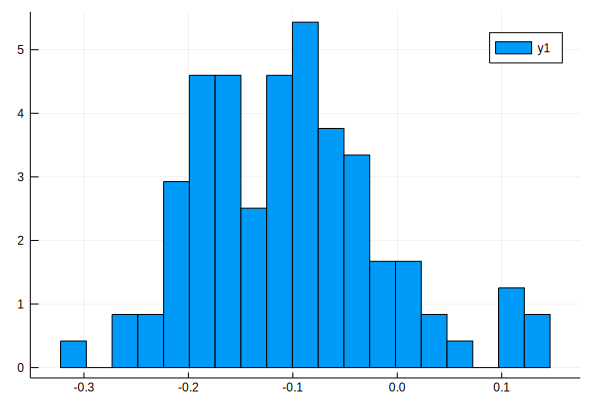

In [51]:
ind = 7
range = 1:100
min_p1 = minimum(plist[range,ind])
max_p1 = maximum(plist[range,ind])
dsp1 = (max_p1 - min_p1) / 20
bins = collect(min_p1:dsp1:max_p1)
p1 = histogram(plist[range,ind],normalize=true,bins = bins)


In [55]:
#=
       Cε = 0.1, surface layer fraction, 1
       Cκ = 0.4, von karman constant, 2
       CN = 6.33, nonlocal flux proportion, 3
    Cstab = 2.0, stabilizes F_b, 4
    Cunst = 6.4, destablizes F_b, 5
     Cb_U = 0.599, convection factor, 6
     Cτ_U = 0.135, wind mixing, 7
     Cb_T = 1.36,convection factor, 8
     Cτ_T = -1.85, wind mixing, 9
     Cd_U = 0.5, dont know, 10
     Cd_T = 2.5, dont know, 11
      CRi = 4.32, unresolved kinetic energy, 12
      CKE = 0.3, richardson number criteria, 13
     CKE₀ = 1e-11,
=#

minv = minimum(vlist)
best_p = plist[argmin(vlist),:]

14-element Array{Float64,1}:
  0.19864225205285774  
 -0.0016947458764786372
 -5.398978546850072    
  1.0230711637103151   
  9.649206178834124    
  1.4918561501526246   
  0.15002959785321202  
  0.7653792451463968   
 -2.5690373852924866   
  0.6200833837410589   
  2.5                  
  4.32                 
  0.3                  
  1.0e-11              

In [82]:
#run with best p
#Gregs Code
# First, we define a model 100 m deep with 1m spacing.
#=
       Cε = 0.1, surface layer fraction, 1
       Cκ = 0.4, von karman constant, 2
       CN = 6.33, nonlocal flux proportion, 3
    Cstab = 2.0, stabilizes F_b, 4
    Cunst = 6.4, destablizes F_b, 5
     Cb_U = 0.599, convection factor, 6
     Cτ_U = 0.135, wind mixing, 7
     Cb_T = 1.36,convection factor, 8
     Cτ_T = -1.85, wind mixing, 9
     Cd_U = 0.5, dont know, 10
     Cd_T = 2.5, dont know, 11
      CRi = 4.32, unresolved kinetic energy, 12
      CKE = 0.3, richardson number criteria, 13
     CKE₀ = 1e-11,
=#
params = best_p
#params = [0.1 0.4 -1*10.33 2.0 6.4 0.599 0.135 1.36 -1.85 0.5 2.5 4.32 0.3 1e-11]
parameters = KPP.Parameters(
    Cε = params[1], Cκ = params[2], CN = params[3], Cstab = params[4], 
    Cunst = params[5], Cb_U = params[6], Cτ_U = params[7], Cb_T  = params[8],
    Cτ_T = params[9], Cd_U = params[10], Cd_T = params[11], CRi = params[12], CKE = params[13]
)

#parameters = KPP.Parameters()
model = KPP.Model(N=128, L=100.0, parameters=parameters)

# Initial condition
γ = 0.01
T₀(z) = 20 + γ*z
N₀ = sqrt(model.constants.g*model.constants.α*γ)

# Set T to the function T0(z)
model.solution.T = T₀

heat_flux = 75
temperature_flux = heat_flux / (model.constants.ρ₀ * model.constants.cP)
buoyancy_flux = temperature_flux * model.constants.g * model.constants.α

model.bcs.T.top = FluxBoundaryCondition(temperature_flux)
model.bcs.T.bottom = GradientBoundaryCondition(γ)

#now iterate the model
# Time stepping
dt = 6 # seconds
#nt = ceil(Int, 86400 / dt) #seconds to days conversion
nt = 3600 #corresponds to LES simulation, 3600*6 seconds is 6 hours
ni = 4*1  #4 corresponds to 1 day

model.solution.T = T₀
U, V, T, S = model.solution
Tz = ∂z(T)

T_p = []
tmp1 = zeros(128)
tmp = data(model.solution.T)
@. tmp1 = tmp
push!(T_p,tmp1[end:-1:1])

reset!(model.clock)
for i in 1:ni
    iterate!(model, dt, nt)
    tmp = data(model.solution.T)
    @. tmp1 = tmp
    push!(T_p,tmp1[end:-1:1])
    println(i)
end

1
2
3
4


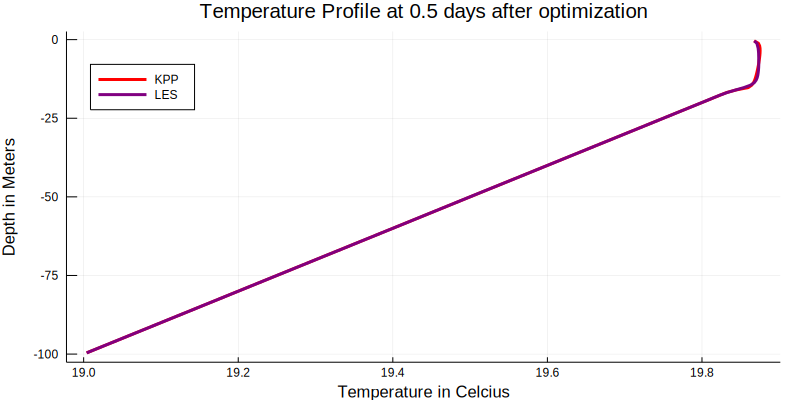

In [83]:
#now plot
index = 3
depth = 1:128 #depth_index_range
plot(T_p[index][depth],z[depth], color = "red",lw = 3, label="KPP",legend=:topleft,frame=true)
plot!(T_s[index][depth],z[depth], title = "Temperature Profile at "*string(t[index]/86400)*" days" * " after optimization ",
    xlabel = "Temperature in Celcius", ylabel = "Depth in Meters",size = (800, 400), color = "purple",lw = 3, label="LES")